In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import cv2 as cv

2025-02-12 23:35:53.637153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_train_file = r"/media/shiva/ML/Computer-Vision/3D_Volumetric_rendering_NERF/dataset/nerf_synthetic/ficus/transforms_train.json"
data_val_file = r'/media/shiva/ML/Computer-Vision/3D_Volumetric_rendering_NERF/dataset/nerf_synthetic/ficus/transforms_val.json'
img_path = r'/media/shiva/ML/Computer-Vision/3D_Volumetric_rendering_NERF/dataset/nerf_synthetic/ficus'

Batch_size = 2
num_samples = 12
POS_ENCODE_DIMS = 8
EPOCHS = 2

with open(data_train_file) as d:
    data_train = json.load(d)
with open(data_val_file) as d:
    data_val = json.load(d)

In [3]:
def load_data(json_file, img_path):
    camera_fov_degree = json_file["camera_angle_x"] * 100
    camera_fov_rad = np.deg2rad(camera_fov_degree)  
    img_list = []
    data_list = []
    
    for d in json_file["frames"]:
        file = d["file_path"]
        file = file.replace(".", img_path)
        img_list.append(f"{file}.png")
        
        data_list.append(d["transform_matrix"])
        
    return img_list, np.array(data_list), camera_fov_rad

In [4]:
train_img, train_data_matrix, camera_fov_rad = load_data(data_train, img_path)
val_img, val_data_matrix, camera_fov_rad = load_data(data_val, img_path)

In [5]:
focal_len = (0.5 * 100) / (np.tan(0.5 * camera_fov_rad))
print(f"focal_length_of_camera: {focal_len}")

focal_length_of_camera: 72.59953237089623


In [6]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (100, 100))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img

def positional_encodeing(x):
    pos = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            pos.append(fn(2.0 ** i * x))
        
    pos = tf.concat(pos, axis = -1)
    
    return pos

def get_rays(focal_point, img_w, img_h, pose_matrix, near, far, num_sample):
    i, j = tf.meshgrid(
        tf.range(img_w, dtype = tf.float32),
        tf.range(img_h, dtype = tf.float32)
    )
    
    x_camera = (i - img_w * 0.5) / focal_point
    y_camera = (j - img_h * 0.5) / focal_point
    direction = tf.stack([x_camera, - y_camera, -tf.ones_like(i)], axis = -1)
    
    camera_matrix = pose_matrix[:3, :3]
    height_width_focal = pose_matrix[:3, -1]
    camera_matrix = tf.cast(camera_matrix, tf.float32)
    height_width_focal = tf.cast(height_width_focal, tf.float32)
    
    # transformed_dir = direction[..., None, :]
    # transformed_dir = tf.cast(transformed_dir, tf.float32)
    # camera_dir = transformed_dir * camera_matrix
    # camera_dir = tf.cast(transformed_dir, tf.float32)
    
    # ray_d = tf.reduce_sum(camera_dir, axis = -1)
    # ray_o = tf.broadcast_to(height_width_focal, tf.shape(ray_d))
    
    transformed_dirs = direction[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_d = tf.reduce_sum(camera_dirs, axis=-1)
    ray_d = ray_d / tf.norm(ray_d, axis = -1, keepdims = True)
    ray_o = tf.broadcast_to(height_width_focal, tf.shape(ray_d))
    
    t_val = tf.linspace(near, far, num_sample)
    shape = list(ray_o.shape[:-1]) + [num_samples]
    noise = tf.random.uniform(shape = shape) * (far - near) / num_sample
    t_val = tf.cast(t_val, tf.float32)
    noise = tf.cast(noise, tf.float32)
    t_val = noise + t_val
    
    # rays = ray_o[..., None, :] + (ray_d[..., None, :] * t_val[..., None])
    # ray_flat = tf.reshape(rays, [-1, 3])
    # ray_flat = positional_encodeing(ray_flat, POS_ENCODE_DIMS)
    
    return (ray_o, ray_d, t_val)

def map_fn(data_matrix):
    ray_o, ray_d, t_val = get_rays(focal_len, 100, 100, data_matrix, 2, 6, num_samples)
    
    return (ray_o, ray_d, t_val)

In [7]:
train_data_img = tf.data.Dataset.from_tensor_slices(train_img)
train_data_img = train_data_img.map(load_img, num_parallel_calls = tf.data.AUTOTUNE)
train_ray = tf.data.Dataset.from_tensor_slices(train_data_matrix)
train_ray = train_ray.map(map_fn, num_parallel_calls = tf.data.AUTOTUNE)
train_data_combined = tf.data.Dataset.zip((train_data_img, train_ray))
train_data_nerf = (
    train_data_combined.shuffle(Batch_size)
    .batch(Batch_size, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# val_data_img = tf.data.Dataset.from_tensor_slices(val_img)
# val_data_img = train_data_img.map(load_img, num_parallel_calls = tf.data.AUTOTUNE)
# val_ray = tf.data.Dataset.from_tensor_slices(val_data_matrix)
# val_ray = val_ray.map(map_fn, num_parallel_calls = tf.data.AUTOTUNE)
# val_data_combined = tf.data.Dataset.zip((val_data_img, val_ray))
# val_data_nerf = (
#     val_data_combined.shuffle(Batch_size)
#     .batch(Batch_size, drop_remainder = True, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

(100, 100, 3)


2025-02-12 23:35:56.328736: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


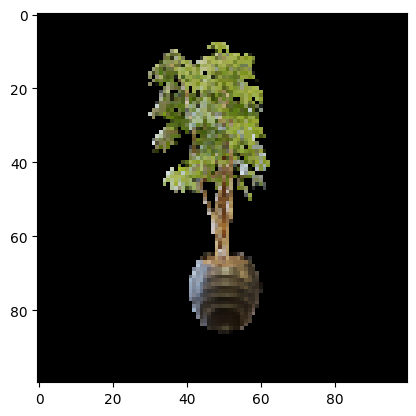

In [8]:
for im, ray_d in train_data_nerf.take(1):
    o, d, t = ray_d
    print(im[0].shape)
    plt.imshow(im[0])

In [9]:
def NeRF_model(num_pose, neurons, num_layers):
    rayInputs = tf.keras.Input(shape=(None, None, None, 2 * 3 * POS_ENCODE_DIMS + 3,), batch_size=Batch_size)
    dirInput = tf.keras.Input(shape=(None, None, None, 2 * 3 * POS_ENCODE_DIMS + 3,), batch_size=Batch_size)
    
    x = rayInputs
    
    for i in range(num_layers):
        x = tf.keras.layers.Dense(neurons, activation = "relu")(x)
        if (i % 4 == 0) and (i > 0):
            x = tf.keras.layers.concatenate([x, rayInputs], axis=-1) 
            
    sigma = tf.keras.layers.Dense(1, activation = "relu")(x)
    feature = tf.keras.layers.Dense(neurons)(x)
    
    feature = tf.keras.layers.concatenate([feature, dirInput], axis = -1)
    x = tf.keras.layers.Dense(neurons // 2, activation = "relu")(feature)
    
    rgb = tf.keras.layers.Dense(3, activation = "sigmoid")(x)
    
    return tf.keras.Model(inputs = [rayInputs, dirInput], outputs = [rgb, sigma])

def render_img_depth(rgb, sigma, t_val):
    sigma = sigma[..., 0]
    
    delta = t_val[..., 1: ] - t_val[..., :-1]
    delta = tf.concat([delta, tf.broadcast_to([1e10], shape = [Batch_size, 100, 100, 1])], axis = -1)
    
    alpha = 1.0 - tf.exp(-sigma * delta)
    
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    
    transmittance = tf.math.cumprod(exp_term + epsilon, axis = -1, exclusive = True)
    weights = alpha * transmittance
    
    image = tf.reduce_sum(weights[..., None] * rgb, axis = -2)
    depth = tf.reduce_sum(weights * t_val, axis = -1)
    
    return (image, depth)
    

In [10]:
class NeRf(tf.keras.Model):
    def __init__(self, nerf_model, render_img_depth, positional_encodeing):
        super().__init__()
        self.nerf_model = nerf_model
        self.render_img_depth = render_img_depth
        self.encode = positional_encodeing
        
    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.psnr_metric = tf.keras.metrics.Mean(name="psnr")
        
    def train_step(self, inputs):
        (images, rays) = inputs
        (ray_o, ray_d, t_val) = rays
        
        raysCoarse = (ray_o[..., None, :] + 
			(ray_d[..., None, :] * t_val[..., None]))
        
        raysCoarse = self.encode(raysCoarse)
        dirCoarseShape = tf.shape(raysCoarse[..., :3])
        dirsCoarse = tf.broadcast_to(ray_d[..., None, :],
			shape = dirCoarseShape)
        dirsCoarse = self.encode(dirsCoarse)
        
        with tf.GradientTape() as tape:
            (rgb, sigma) = self.nerf_model([raysCoarse, dirsCoarse])
            img, depth = self.render_img_depth(rgb, sigma, t_val)
            
            loss = self.loss_fn(images, img)
            
        trainable_variables = self.nerf_model.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        psnr = tf.image.psnr(images, img, max_val=1.0)

        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}
    
    def test_step(self, inputs):
        (images, rays) = inputs
        (ray_o, ray_d, t_val) = rays
        
        raysCoarse = (ray_o[..., None, :] + 
			(ray_d[..., None, :] * t_val[..., None]))
        
        raysCoarse = self.encode(raysCoarse)
        dirCoarseShape = tf.shape(raysCoarse[..., :3])
        dirsCoarse = tf.broadcast_to(ray_d[..., None, :],
			shape = dirCoarseShape)
        dirsCoarse = self.encode(dirsCoarse)
        
        (rgb, sigma) = self.nerf_model([raysCoarse, dirsCoarse])
        img, depth = self.render_img_depth(rgb, sigma, t_val)
        
        loss = self.loss_fn(images, img)

        psnr = tf.image.psnr(images, img, max_val=1.0)

        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

In [ ]:
loss_list = []
test_imgs, test_rays = next(iter(train_data_nerf))
test_ray_o, test_ray_d, test_t_vals = test_rays

test_raysCoarse = (test_ray_o[..., None, :] + 
			(test_ray_d[..., None, :] * test_t_vals[..., None]))

test_raysCoarse = positional_encodeing(test_raysCoarse)
test_dirCoarseShape = tf.shape(test_raysCoarse[..., :3])
test_dirsCoarse = tf.broadcast_to(test_ray_d[..., None, :],
			shape = test_dirCoarseShape)
test_dirsCoarse = positional_encodeing(test_dirsCoarse)

class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        
        (rgb, sigma) = self.model.nerf_model([test_raysCoarse, test_dirsCoarse])
        img, depth = render_img_depth(rgb, sigma, test_t_vals)
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(img[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(depth[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        # fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

In [12]:
num_pos = 100 * 100 * num_samples
model_n = NeRF_model(num_pos, 64, 8)

model = NeRf(model_n, render_img_depth, positional_encodeing)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss_fn = tf.keras.losses.MeanSquaredError())

In [13]:
model.summary()

Model: "ne_rf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ ((2, None, None, None, │        43,748 │
│                                 │ 3), (2, None, None,    │               │
│                                 │ None, 1))              │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,748 (170.89 KB)

 Trainable params: 43,748 (170.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0974 - psnr: 12.0636

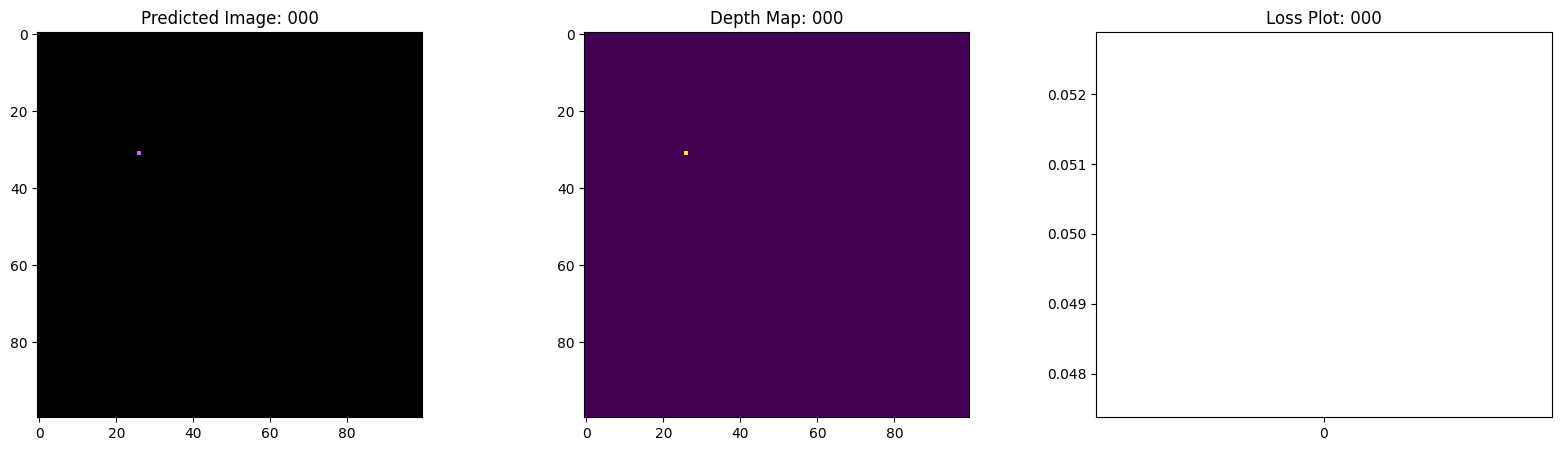

50/50 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - loss: 0.0964 - psnr: 12.1070
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0299 - psnr: 15.3167

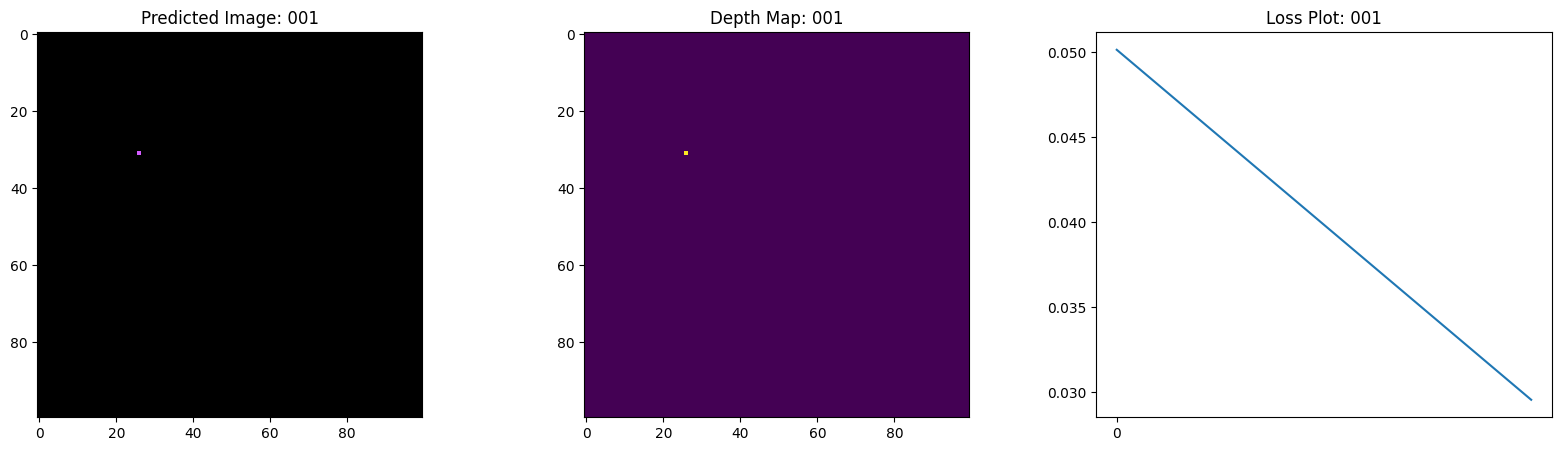

50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - loss: 0.0299 - psnr: 15.3175


In [14]:
model.fit(
    train_data_nerf,
    batch_size = 2,
    epochs = 2,
    callbacks = [TrainMonitor()],
)